### Подключение к базе и основные таблицы

In [1]:
import pandas as pd

### Данные по пользователям

user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [2]:
### Посты и темы

posts_info = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [3]:
### Почти 77 миллионов записей, слишком много для локальной обработки

count_feed_data = pd.read_sql(
    """SELECT count(*) FROM public.feed_data""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

count_feed_data.head()

,count
0,76892800


In [4]:
### Заберем 10 миллионов записей

feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 10000000""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-11-18 07:01:27,146904,6181,view,0
1,2021-11-18 07:02:45,146904,304,view,0
2,2021-11-18 07:05:35,146904,5489,view,1
3,2021-11-18 07:08:28,146904,5489,like,0
4,2021-11-18 07:08:30,146904,3764,view,1


### Работа с данными и фичи для контентной модели

In [5]:
### Рассмотрим колонку action

feed_data[feed_data.action!='view']

,timestamp,user_id,post_id,action,target
3,2021-11-18 07:08:28,146904,5489,like,0
5,2021-11-18 07:11:26,146904,3764,like,0
29,2021-11-24 19:28:58,146904,212,like,0
34,2021-11-24 19:33:03,146904,7022,like,0
70,2021-11-25 13:43:30,146904,4609,like,0
...,...,...,...,...,...
9999955,2021-10-17 22:15:58,104951,7012,like,0
9999961,2021-10-17 22:24:25,104951,3507,like,0
9999966,2021-10-17 22:32:35,104951,6710,like,0
9999975,2021-10-23 09:50:05,104951,1016,like,0


In [6]:
### Почистим данные от action != view, т.к таргет указывает на лайк

feed_data = feed_data[feed_data.action=='view']

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-11-18 07:01:27,146904,6181,view,0
1,2021-11-18 07:02:45,146904,304,view,0
2,2021-11-18 07:05:35,146904,5489,view,1
4,2021-11-18 07:08:30,146904,3764,view,1
6,2021-11-18 07:11:28,146904,6028,view,0


In [7]:
### Необходимо по user_id выделять фиксированный набор признаков
user_info

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [8]:
posts_info

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [9]:
### Придумаем эмбеединг для текстов!

import re
import string

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

In [10]:
tfidf_data = (
    tfidf
    .fit_transform(posts_info['text'])
    .toarray()
)

tfidf_data

C:\Users\Ratibor_Sergeev\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn(


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.13273932, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05061394, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [11]:
tfidf_data = pd.DataFrame(
    tfidf_data,
    index=posts_info.post_id,
    columns=tfidf.get_feature_names_out()
)

tfidf_data

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7316,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7317,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
### Генерим фичи на основе TfIdf

posts_info['TotalTfIdf'] = tfidf_data.sum(axis=1).reset_index()[0]
posts_info['MaxTfIdf'] = tfidf_data.max(axis=1).reset_index()[0]
posts_info['MeanTfIdf'] = tfidf_data.mean(axis=1).reset_index()[0]

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138


In [13]:
### Кластеризуем тексты

from sklearn.decomposition import PCA

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

posts_info['TextCluster'] = kmeans.labels_

dists_columns = [f"DistanceTo{ith}thCluster" for ith in range(1, 16)]

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

C:\Users\Ratibor_Sergeev\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.508151,0.389592,0.438321,0.467679,0.450447,0.467744,0.152349,0.531769,0.480900,0.463188,0.444564,0.501197,0.526044,0.537076,0.686526
1,0.380151,0.159122,0.282336,0.327130,0.305673,0.336353,0.250688,0.268088,0.342266,0.312846,0.278744,0.422574,0.410164,0.429793,0.572321
2,0.397571,0.240597,0.310431,0.365955,0.333600,0.348875,0.122690,0.477660,0.365674,0.355778,0.324500,0.426589,0.435308,0.469068,0.529458
3,0.361747,0.162736,0.257640,0.325003,0.273250,0.309101,0.220275,0.429700,0.325603,0.302272,0.287163,0.402729,0.389147,0.430516,0.440696
4,0.304807,0.094066,0.166511,0.304389,0.197660,0.247900,0.281128,0.392019,0.263593,0.251828,0.219629,0.349736,0.343255,0.388913,0.504175


In [14]:
posts_info = pd.concat((posts_info,dists_df), axis=1)

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,6,0.508151,0.389592,0.438321,...,0.467744,0.152349,0.531769,0.480900,0.463188,0.444564,0.501197,0.526044,0.537076,0.686526
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,1,0.380151,0.159122,0.282336,...,0.336353,0.250688,0.268088,0.342266,0.312846,0.278744,0.422574,0.410164,0.429793,0.572321
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,6,0.397571,0.240597,0.310431,...,0.348875,0.122690,0.477660,0.365674,0.355778,0.324500,0.426589,0.435308,0.469068,0.529458
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,1,0.361747,0.162736,0.257640,...,0.309101,0.220275,0.429700,0.325603,0.302272,0.287163,0.402729,0.389147,0.430516,0.440696
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,1,0.304807,0.094066,0.166511,...,0.247900,0.281128,0.392019,0.263593,0.251828,0.219629,0.349736,0.343255,0.388913,0.504175


In [15]:
### Соберём датафрейм со всеми новыми фичами 

df = pd.merge(feed_data,
              posts_info,
              on='post_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,2021-11-18 07:01:27,146904,6181,view,0,That is the best way I can describe this movie...,movie,8.598785,0.226436,0.000187,...,0.133747,0.377673,0.454797,0.214520,0.341736,0.295391,0.402477,0.397411,0.403049,0.618944
1,2021-11-18 07:02:45,146904,304,view,0,"India calls for fair trade rules\n\nIndia, whi...",business,8.767736,0.377304,0.000191,...,0.354552,0.143066,0.391872,0.365103,0.384280,0.303004,0.392941,0.417027,0.454578,0.567924
2,2021-11-18 07:05:35,146904,5489,view,1,I can give you four reasons to see this movie:...,movie,10.524547,0.236048,0.000229,...,0.236508,0.427976,0.495249,0.257709,0.393195,0.341979,0.441167,0.446222,0.438823,0.619149
3,2021-11-18 07:08:30,146904,3764,view,1,Fujian reports one new imported #COVID19 case ...,covid,3.227833,0.645911,0.000070,...,0.302674,0.346440,0.429796,0.318398,0.330711,0.272520,0.370286,0.307475,0.423526,0.593259
4,2021-11-18 07:11:28,146904,6028,view,0,My family and I screened Underdog the night be...,movie,6.723439,0.395950,0.000146,...,0.167110,0.412120,0.475133,0.294621,0.383354,0.310536,0.425941,0.437630,0.421284,0.643329


In [16]:
df = pd.merge(df,
              user_info,
              on='user_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source
0,2021-11-18 07:01:27,146904,6181,view,0,That is the best way I can describe this movie...,movie,8.598785,0.226436,0.000187,...,0.397411,0.403049,0.618944,1,47,Russia,Vladikavkaz,0,Android,organic
1,2021-11-18 07:02:45,146904,304,view,0,"India calls for fair trade rules\n\nIndia, whi...",business,8.767736,0.377304,0.000191,...,0.417027,0.454578,0.567924,1,47,Russia,Vladikavkaz,0,Android,organic
2,2021-11-18 07:05:35,146904,5489,view,1,I can give you four reasons to see this movie:...,movie,10.524547,0.236048,0.000229,...,0.446222,0.438823,0.619149,1,47,Russia,Vladikavkaz,0,Android,organic
3,2021-11-18 07:08:30,146904,3764,view,1,Fujian reports one new imported #COVID19 case ...,covid,3.227833,0.645911,0.000070,...,0.307475,0.423526,0.593259,1,47,Russia,Vladikavkaz,0,Android,organic
4,2021-11-18 07:11:28,146904,6028,view,0,My family and I screened Underdog the night be...,movie,6.723439,0.395950,0.000146,...,0.437630,0.421284,0.643329,1,47,Russia,Vladikavkaz,0,Android,organic


In [17]:
### Выделим признаки из timestamp

df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source,hour,month
0,2021-11-18 07:01:27,146904,6181,view,0,That is the best way I can describe this movie...,movie,8.598785,0.226436,0.000187,...,0.618944,1,47,Russia,Vladikavkaz,0,Android,organic,7,11
1,2021-11-18 07:02:45,146904,304,view,0,"India calls for fair trade rules\n\nIndia, whi...",business,8.767736,0.377304,0.000191,...,0.567924,1,47,Russia,Vladikavkaz,0,Android,organic,7,11
2,2021-11-18 07:05:35,146904,5489,view,1,I can give you four reasons to see this movie:...,movie,10.524547,0.236048,0.000229,...,0.619149,1,47,Russia,Vladikavkaz,0,Android,organic,7,11
3,2021-11-18 07:08:30,146904,3764,view,1,Fujian reports one new imported #COVID19 case ...,covid,3.227833,0.645911,0.000070,...,0.593259,1,47,Russia,Vladikavkaz,0,Android,organic,7,11
4,2021-11-18 07:11:28,146904,6028,view,0,My family and I screened Underdog the night be...,movie,6.723439,0.395950,0.000146,...,0.643329,1,47,Russia,Vladikavkaz,0,Android,organic,7,11


In [18]:
### Уберем все ненужные колонки

df = df.drop([
    'action',
    'text',
],
    axis=1)

df = df.set_index(['user_id', 'post_id'])

df.head(50)

timestamp  target          topic  TotalTfIdf  \
user_id post_id                                                          
146904  6181    2021-11-18 07:01:27       0          movie    8.598785   
        304     2021-11-18 07:02:45       0       business    8.767736   
        5489    2021-11-18 07:05:35       1          movie   10.524547   
        3764    2021-11-18 07:08:30       1          covid    3.227833   
        6028    2021-11-18 07:11:28       0          movie    6.723439   
        2522    2021-11-18 07:14:23       0          covid    3.407590   
        4657    2021-11-18 07:14:45       0          movie    6.468639   
        383     2021-11-18 07:15:30       0       business    5.676776   
        5915    2021-11-18 07:17:47       0          movie    6.681197   
        1433    2021-11-18 07:18:58       0          sport    6.815409   
        5640    2021-11-18 07:19:54       0          movie   10.534931   
        3023    2021-11-18 07:20:33       0          covid    3.257599   
        1972    2021-11-18 07:20:49       0           tech   11.553741   
        3850    2021-11-18 07:22:24       0          covid    3.207320   
        4755    2021-11-18 07:22:53       0          movie    7.526367   
        2807    2021-11-18 07:25:15       0          covid    3.110451   
        5368    2021-11-18 07:27:50       0          movie    7.439722   
        1446    2021-11-18 07:29:22       0          sport    8.306820   
        5187    2021-11-18 07:29:46       0          movie    9.153785   
        1830    2021-11-18 07:31:30       0          sport   11.334856   
        6873    2021-11-18 07:34:05       0          movie   10.758583   
        3865    2021-11-18 07:36:52       0          covid    3.280312   
        1694    2021-11-18 07:39:13       0          sport   14.620331   
        2       2021-11-18 07:40:32       0       business   11.878472   
        5525    2021-11-18 07:42:29       0          movie    4.420829   
        1358    2021-11-18 07:44:46       0       politics    7.593699   
        212     2021-11-24 19:28:49       1       business    7.256164   
        3710    2021-11-24 19:29:00       0          covid    3.968658   
        2595    2021-11-24 19:29:57       0          covid    2.627268   
        5950    2021-11-24 19:32:13       0          movie    7.732659   
        7022    2021-11-24 19:32:48       1          movie    8.042202   
        4563    2021-11-24 19:33:05       0          movie    5.255086   
        6135    2021-11-24 19:33:54       0          movie    7.268022   
        171     2021-11-24 19:36:29       0       business    7.076056   
        890     2021-11-24 19:37:04       0  entertainment    9.914078   
        6499    2021-11-24 19:39:04       0          movie    6.349997   
        5691    2021-11-24 19:39:40       0          movie   17.031392   
        926     2021-11-24 19:40:21       0  entertainment    9.470266   
        6349    2021-11-24 19:41:19       0          movie    3.154378   
        7299    2021-11-24 19:42:09       0          movie    6.281160   
        3129    2021-11-24 19:42:47       0          covid    2.661944   
        5867    2021-11-24 19:43:37       0          movie    5.468838   
        3801    2021-11-24 19:44:40       0          covid    3.610362   
        3886    2021-11-24 19:45:46       0          covid    3.110666   
        2931    2021-11-24 19:47:33       0          covid    3.445548   
        2872    2021-11-24 19:48:43       0          covid    3.343721   
        3518    2021-11-24 19:51:02       0          covid    3.801364   
        1484    2021-11-24 19:52:34       0          sport   10.051781   
        6186    2021-11-24 19:54:12       0          movie   10.703443   
        5183    2021-11-24 19:56:14       0          movie    6.587261   

                 MaxTfIdf  MeanTfIdf  TextCluster  DistanceTo1thCluster  \
user_id post_id                                                           
146904  6181     0.226436  

### Обучение модели! 

In [19]:
### Построим Бэйзлайн при помощи обычного дерева
### А после используем Бустинг

### Разобьём данные на трейн и тест в соответствии с временной структурой

max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:51:06'), Timestamp('2021-10-01 06:05:25'))

In [20]:
### Возьмем за отсечку 2021-12-15

df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((7448511,), (1484181,))

In [21]:
X_train

topic  TotalTfIdf  MaxTfIdf  MeanTfIdf  TextCluster  \
user_id post_id                                                           
146904  6181        movie    8.598785  0.226436   0.000187            5   
        304      business    8.767736  0.377304   0.000191            6   
        5489        movie   10.524547  0.236048   0.000229            0   
        3764        covid    3.227833  0.645911   0.000070            4   
        6028        movie    6.723439  0.395950   0.000146            0   
...                   ...         ...       ...        ...          ...   
104951  1300     politics    8.625053  0.359452   0.000188            7   
        3820        covid    3.077519  0.453246   0.000067            4   
        6282        movie   10.603943  0.337812   0.000231            8   
        979      politics    8.430385  0.683015   0.000183            7   
        1894        sport    9.332158  0.393118   0.000203           11   

                 DistanceTo1thCluster  DistanceTo2thCluster  \
user_id post_id                                               
146904  6181                 0.137508              0.260958   
        304                  0.398603              0.227799   
        5489                 0.165731              0.334026   
        3764                 0.353273              0.216354   
        6028                 0.156572              0.298217   
...                               ...                   ...   
104951  1300                 0.558375              0.420840   
        3820                 0.328607              0.244718   
        6282                 0.292120              0.206522   
        979                  0.383577              0.228040   
        1894                 0.407428              0.319996   

                 DistanceTo3thCluster  DistanceTo4thCluster  \
user_id post_id                                               
146904  6181                 0.154603              0.361283   
        304                  0.310459              0.392525   
        5489                 0.224341              0.432048   
        3764                 0.239307              0.369742   
        6028                 0.245878              0.382738   
...                               ...                   ...   
104951  1300                 0.502341              0.542972   
        3820                 0.214809              0.377902   
        6282                 0.126448              0.347820   
        979                  0.284612              0.390818   
        1894                 0.318447              0.422542   

                 DistanceTo5thCluster  ...  DistanceTo15thCluster  gender  \
user_id post_id                        ...                                  
146904  6181                 0.279005  ...               0.618944       1   
        304                  0.318019  ...               0.567924       1   
        5489                 0.348824  ...               0.619149       1   
        3764                 0.123913  ...               0.593259       1   
        6028                 0.335140  ...               0.643329       1   
...                               ...  ...                    ...     ...   
104951  1300                 0.522444  ...               0.733147       1   
        3820                 0.072287  ...               0.579588       1   
        6282                 0.237029  ...               0.587813       1   
        979                  0.312086  ...               0.604513       1   
        1894                 0.338321  ...               0.627343       1   

                 age  country         city  exp_group       os   source  hour  \
user_id post_id                                                                 
146904  6181      47   Russia  Vladikavkaz          0  Android  organic     7   
        304       47   Russia  Vladikavkaz          0  Android  organic     7   
        5489      47   Russia  Vladikavkaz          0  Android  organic     7 

In [22]:
### Начнем с решающего дерева

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]

### Cохраним индексы этих колонок

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("decision_tree", 
                     DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [20, 28, 25, 26]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 4, 22, 23, 24, 27])])),
                ('decision_tree', DecisionTreeClassifier())])

In [23]:
### Замерим качество работы модели на ROC-AUC
### Как видно из разница ROC-AUC-ов - модель сильно переобучилась
### ROC-AUC в 0.53 указывает на то, что модель предсказывает лишь чуть лучше, чем подбрасывание монетки :<

from sklearn.metrics import roc_auc_score

print(f"Качество на трейне: {roc_auc_score(y_train, pipe_dt.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.9022698988987203
Качество на тесте: 0.538280959768855


In [24]:
### Обучим CatBoost

from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2)

catboost.fit(X_train, y_train, object_cols)

0:	learn: 0.3561739	total: 2.27s	remaining: 3m 44s
1:	learn: 0.3491287	total: 4.41s	remaining: 3m 35s
2:	learn: 0.3479421	total: 6.23s	remaining: 3m 21s
3:	learn: 0.3471362	total: 8.19s	remaining: 3m 16s
4:	learn: 0.3469764	total: 9.91s	remaining: 3m 8s
5:	learn: 0.3468629	total: 11.5s	remaining: 3m
6:	learn: 0.3467801	total: 13.1s	remaining: 2m 54s
7:	learn: 0.3463775	total: 14.6s	remaining: 2m 47s
8:	learn: 0.3459274	total: 16.2s	remaining: 2m 44s
9:	learn: 0.3458554	total: 17.8s	remaining: 2m 40s
10:	learn: 0.3455356	total: 19.2s	remaining: 2m 35s
11:	learn: 0.3455030	total: 20.6s	remaining: 2m 31s
12:	learn: 0.3454832	total: 22.1s	remaining: 2m 28s
13:	learn: 0.3454564	total: 23.6s	remaining: 2m 25s
14:	learn: 0.3454287	total: 25s	remaining: 2m 21s
15:	learn: 0.3449704	total: 26.5s	remaining: 2m 19s
16:	learn: 0.3445140	total: 28s	remaining: 2m 16s
17:	learn: 0.3442200	total: 29.4s	remaining: 2m 13s
18:	learn: 0.3439423	total: 30.9s	remaining: 2m 11s
19:	learn: 0.3436020	total: 32.

In [25]:
### Замерим качество работы CatBoost-а на ROC-AUC
### Ситуация намного лучше! :D 
### Модель не переобучилась и ROC-AUC значительно выше

print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6676937310837383
Качество на тесте: 0.6516231755017827


C:\Users\Ratibor_Sergeev\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ratibor_Sergeev\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ratibor_Sergeev\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


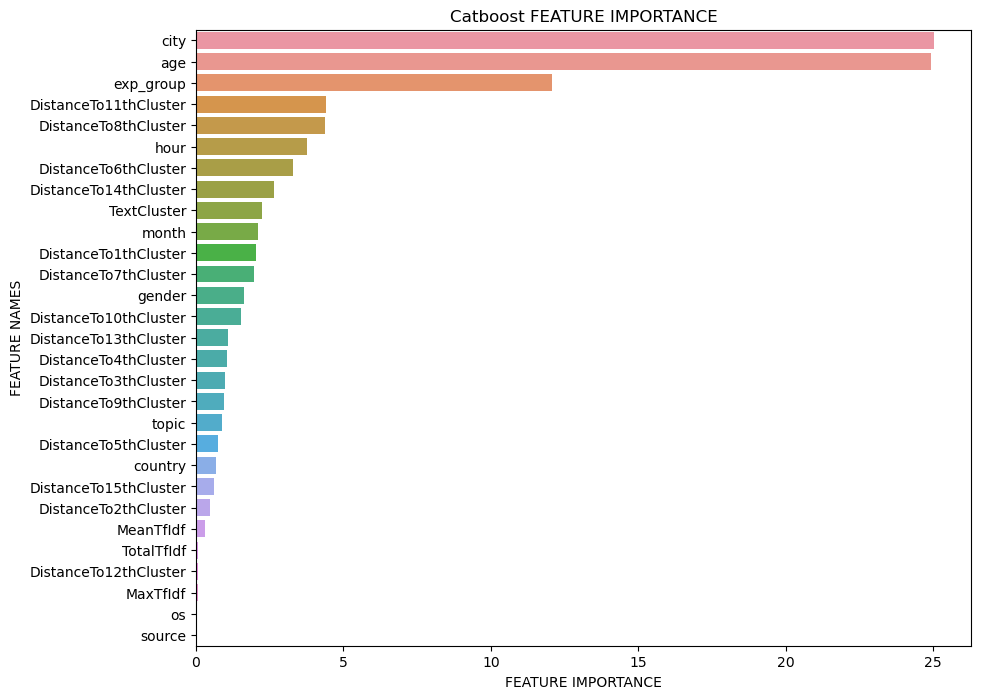

In [26]:
### Посмотрим на feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')

In [27]:
### Сохраним модель

catboost.save_model(
    'catboost_model_classic_ml',
    format="cbm"                  
)

### Положим в базу данных фичи, необходимые для функционала нашей модели

In [28]:
posts_info.to_sql(    
   "posts_info_features",                    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",                
    if_exists='replace'            
   )                               
                                   

23

In [29]:
### Проверим, что данные успешно сохранены

test_ = pd.read_sql(
    """SELECT * FROM public.posts_info_features""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

test_

,index,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,6,0.508151,0.389592,...,0.467744,0.152349,0.531769,0.480900,0.463188,0.444564,0.501197,0.526044,0.537076,0.686526
1,1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,1,0.380151,0.159122,...,0.336353,0.250688,0.268088,0.342266,0.312846,0.278744,0.422574,0.410164,0.429793,0.572321
2,2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,6,0.397571,0.240597,...,0.348875,0.122690,0.477660,0.365674,0.355778,0.324500,0.426589,0.435308,0.469068,0.529458
3,3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,1,0.361747,0.162736,...,0.309101,0.220275,0.429700,0.325603,0.302272,0.287163,0.402729,0.389147,0.430516,0.440696
4,4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,1,0.304807,0.094066,...,0.247900,0.281128,0.392019,0.263593,0.251828,0.219629,0.349736,0.343255,0.388913,0.504175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7017,7314,Although the likeliness of someone focusing on...,movie,10.326422,0.300231,0.000224,0,0.248426,0.461495,...,0.339767,0.537208,0.577263,0.417269,0.511022,0.467890,0.551133,0.560692,0.568114,0.707496
7019,7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,6.703302,0.258412,0.000146,0,0.137974,0.339303,...,0.165473,0.437290,0.494871,0.319705,0.411443,0.345287,0.452256,0.449254,0.483864,0.647455
7020,7020,7317,I cant believe this film was allowed to be mad...,movie,5.628524,0.573061,0.000122,8,0.289984,0.252549,...,0.196012,0.376355,0.453855,0.063879,0.342663,0.275591,0.400937,0.378705,0.389791,0.607113
7021,7021,7318,The version I saw of this film was the Blockbu...,movie,6.883375,0.231244,0.000150,5,0.299197,0.269082,...,0.166343,0.381983,0.448943,0.172590,0.356444,0.294880,0.404255,0.411749,0.353841,0.591806
